# Import dependencies

In [1]:
from ucimlrepo import fetch_ucirepo, list_available_datasets
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA 
import scipy.cluster.hierarchy as shc 
from sklearn.model_selection import KFold

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import import_dataset, encode_categorical_features, test_classifier, agg_clustering


# Config Params

In [2]:
TEST_SIZE = 0.2
RANDOM_SEED = 42
K_FOLDS = 3

# Our chosen datasets
TODO
We have chosen the datasets based on the following criteria:
- datasets where we do not need to do any special preprocessing so that it is easy to do in only one pipeline
- rather small datasets to ensure we do not need high computational power

In [3]:
# Dataset that seems useful
dataset_id = {
    "iris": 53, 
    "heart_disease": 45, 
    "wine_quality": 186, 
    "breast_cancer_wisconsin_diagnostic": 17, 
    "car_evaluation": 19, 
    #"abalone": 1, 
    "mushroom": 73, 
    "statlog" : 144, 
    "credit_approval" : 27, 
    "zoo" : 111, 
    "balance_scale" : 12, 
    "ilpd" : 225, 
    "acute_inflamations" : 184, 
    "ecoli" : 39, 
    "mammographic_mass" : 161, 
    "hayes_roth" : 44, 
    "habermans_survival" : 43, 
    "congress_voting_records" : 105, 
    "balloons" : 13, 
    "lenses" : 58, 
    "fertility" : 244, 
}

data_set_sorted = {}
for i, name in enumerate(sorted(dataset_id.keys())):
    data_set_sorted[name] =(dataset_id[name], i)

print(data_set_sorted)


{'abalone': (1, 0), 'acute_inflamations': (184, 1), 'balance_scale': (12, 2), 'balloons': (13, 3), 'breast_cancer_wisconsin_diagnostic': (17, 4), 'car_evaluation': (19, 5), 'congress_voting_records': (105, 6), 'credit_approval': (27, 7), 'ecoli': (39, 8), 'fertility': (244, 9), 'habermans_survival': (43, 10), 'hayes_roth': (44, 11), 'heart_disease': (45, 12), 'ilpd': (225, 13), 'iris': (53, 14), 'lenses': (58, 15), 'mammographic_mass': (161, 16), 'mushroom': (73, 17), 'statlog': (144, 18), 'wine_quality': (186, 19), 'zoo': (111, 20)}


# Import and preprocess datasets
For the preprocessing we will do the following steps:
1. Remove any missing values. In the article the following is written: "Given that our classifiers are not oriented to data with missing features, the missing inputs are treated as zero, which should not bias the comparison results." We therefore also decided to just remove missing values and to more focus on the full pipeline instead of single datasets. Another way could have been interpolation.
2. Encode categorical data into numerical data. This we have to do to use the classifiers later on.
3. Remove certain columns if they are highly correlated to others.
4. Split the data into a train and a test set. We will use a 80/20 split.
5. Scale the data so that we have zero mean and standard deviation of one. This is done with the Standard scaler.

In [4]:
# import docx
# from docx import Document

# def exp_images(images):  # export images to word file
#     document = Document()
#     paragraph = document.add_paragraph()
#     script = paragraph.add_run()
#     script.add_text('This is a test sentence')

#     # loop through a list of images and add each one to the document
#     for image in images:
#         # add a line break between the text and the image
#         script.add_break(docx.enum.text.WD_BREAK.LINE)
#         # add the image to the document
#         script.add_picture(image, width=Inches(6.5))

#     document.save('demo.docx')

In [5]:
for name, id in data_set_sorted.items():

        print(name)
    
        ordinal_encoder = OrdinalEncoder()
        X, y = import_dataset(dataset_id[name], ordinal_encoder)
        y = encode_categorical_features(y, ordinal_encoder)

        # split the dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y)

        # KNN
        # https://towardsdatascience.com/gridsearchcv-for-beginners-db48a90114ee
        knn = KNeighborsClassifier()
        params = [{'knn__n_neighbors': [3, 5, 7, 9],
                'knn__weights': ['uniform', 'distance'],
                'knn__leaf_size': [15, 20]}]

        cm_train = test_classifier(knn, "knn", params, X_train, y_train, X_test, y_test)
        
        
        
        filename = "test.txt"
        with open(filename, "a") as f:
                f.write(name)
                f.write('\n')
                f.write(np.array2string(cm_train, separator=', '))
                f.write('\n')
                f.write('\n')

abalone
['Sex']


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [ ]:
ordinal_encoder = OrdinalEncoder()
X, y = import_dataset(dataset_id["wine_quality"], ordinal_encoder)
y = encode_categorical_features(y, ordinal_encoder)

[]


In [7]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

# Testing different classifiers

# K-Nearest Neighbor classifier

c:\Users\britt\anaconda3\envs\AppliedAILabs\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


{'knn__leaf_size': 15, 'knn__n_neighbors': 9, 'knn__weights': 'distance'}
knn, Train accuracy = 1.0, Test accuracy = 0.6584615384615384
knn, Train f1-score = 1.0, Test f1-score = 0.6499910171640016
Confusion Matrix for train set


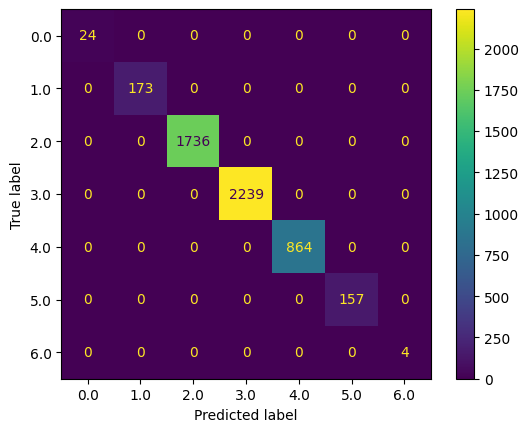

Confusion Matrix for test set


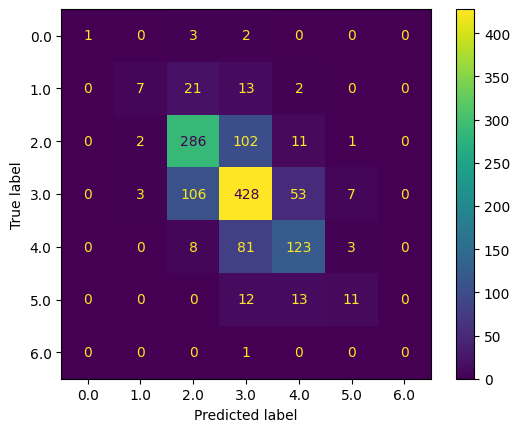

array([[  24,    0,    0,    0,    0,    0,    0],
       [   0,  173,    0,    0,    0,    0,    0],
       [   0,    0, 1736,    0,    0,    0,    0],
       [   0,    0,    0, 2239,    0,    0,    0],
       [   0,    0,    0,    0,  864,    0,    0],
       [   0,    0,    0,    0,    0,  157,    0],
       [   0,    0,    0,    0,    0,    0,    4]], dtype=int64)

In [ ]:
# https://towardsdatascience.com/gridsearchcv-for-beginners-db48a90114ee
knn = KNeighborsClassifier()
params = [{'knn__n_neighbors': [3, 5, 7, 9],
         'knn__weights': ['uniform', 'distance'],
         'knn__leaf_size': [15, 20]}]

test_classifier(knn, "knn", params, X_train, y_train, X_test, y_test)


# SVM

c:\Users\britt\anaconda3\envs\AppliedAILabs\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


{'svm__C': 10, 'svm__gamma': 1, 'svm__kernel': 'rbf'}
svm, Train accuracy = 0.9951895324225515, Test accuracy = 0.6384615384615384
svm, Train f1-score = 0.9951902890902109, Test f1-score = 0.6296839877108256
Confusion Matrix for train set


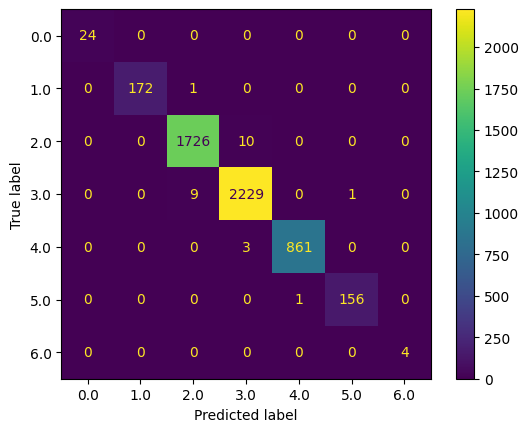

Confusion Matrix for test set


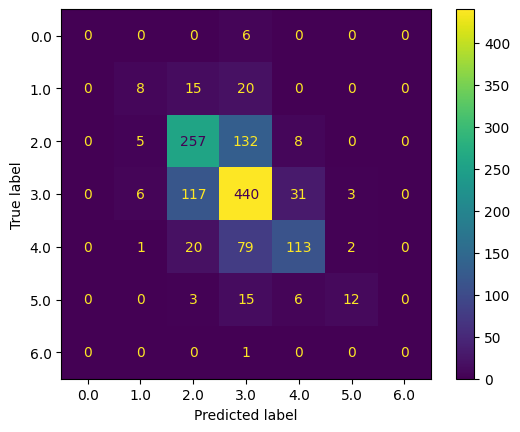

array([[  24,    0,    0,    0,    0,    0,    0],
       [   0,  172,    1,    0,    0,    0,    0],
       [   0,    0, 1726,   10,    0,    0,    0],
       [   0,    0,    9, 2229,    0,    1,    0],
       [   0,    0,    0,    3,  861,    0,    0],
       [   0,    0,    0,    0,    1,  156,    0],
       [   0,    0,    0,    0,    0,    0,    4]], dtype=int64)

In [9]:
svm = SVC()
# params taken from here: https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/
params = [{'svm__C': [0.1, 1, 10, 100, 1000],  
              'svm__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'svm__kernel': ['rbf']} ]

test_classifier(svm, "svm", params, X_train, y_train, X_test, y_test)

# Linear Regression

c:\Users\britt\anaconda3\envs\AppliedAILabs\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\britt\anaconda3\envs\AppliedAILabs\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\britt\anaconda3\envs\AppliedAILabs\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or sc

{'log_reg__C': 100.0, 'log_reg__max_iter': 100, 'log_reg__penalty': 'l2'}
log_reg, Train accuracy = 0.552241677891091, Test accuracy = 0.5376923076923077
log_reg, Train f1-score = 0.5196861580744029, Test f1-score = 0.5037079091157856
Confusion Matrix for train set


c:\Users\britt\anaconda3\envs\AppliedAILabs\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
140 fits failed out of a total of 280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\britt\anaconda3\envs\AppliedAILabs\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\britt\anaconda3\envs\AppliedAILabs\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\britt\anaconda3\envs\AppliedAILabs\Lib\sit

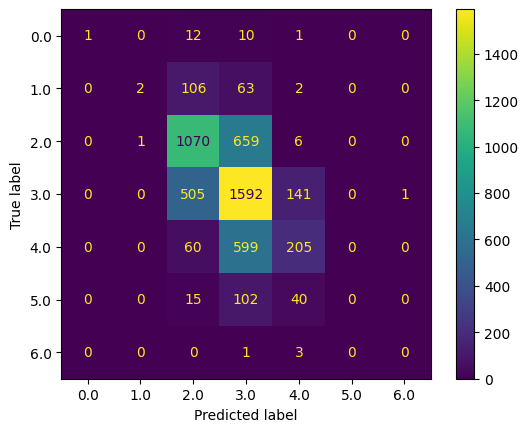

Confusion Matrix for test set


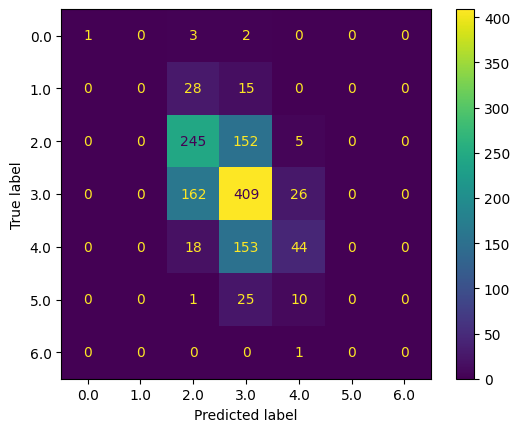

array([[   1,    0,   12,   10,    1,    0,    0],
       [   0,    2,  106,   63,    2,    0,    0],
       [   0,    1, 1070,  659,    6,    0,    0],
       [   0,    0,  505, 1592,  141,    0,    1],
       [   0,    0,   60,  599,  205,    0,    0],
       [   0,    0,   15,  102,   40,    0,    0],
       [   0,    0,    0,    1,    3,    0,    0]], dtype=int64)

In [10]:
log_reg = LogisticRegression()
# params taken from here: https://www.geeksforgeeks.org/how-to-optimize-logistic-regression-performance/
# and from here https://www.kaggle.com/code/enespolat/grid-search-with-logistic-regression
params = [
    {'log_reg__penalty':['l1','l2'],
    'log_reg__C' : np.logspace(-3,3,7),
    'log_reg__max_iter'  : [100,1000,2500,5000]
}
]

test_classifier(log_reg, "log_reg", params, X_train, y_train, X_test, y_test)

# Unsupervised Classification

# Add Agglomerative Clustering
https://www.geeksforgeeks.org/implementing-agglomerative-clustering-using-sklearn/

In [ ]:
agg_clustering(X_train, y_train, X_test, y_test)

Best score 0.43377312873143536 with params {'metric': 'euclidean', 'linkage': 'single', 'pca': True}
Test accuracy = 0.4623076923076923
